In [2]:
import pandas as pd
import numpy as np
from glob import glob
import os

from sklearn.model_selection import train_test_split


# Gathering data
* Collecting all image paths and associating them with there respective image ids


In [3]:
data_dir = 'data'
all_image_paths = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_paths}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
meta_df = pd.read_csv('data/HAM10000_metadata.csv')
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
# add image paths to meta_df
meta_df['path'] = meta_df['image_id'].map(imageid_path_dict.get)
meta_df['cell_type'] = meta_df['dx'].map(lesion_type_dict.get)
meta_df['cell_type_idx'] = pd.Categorical(meta_df['cell_type']).codes
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [6]:
# create a id2label mapping base on cell_type_idx
id2label = meta_df[['cell_type_idx', 'cell_type']].drop_duplicates().sort_values('cell_type_idx')
id2label = id2label.set_index('cell_type_idx').to_dict()['cell_type']
id2label[6] = 'Melanoma'
id2label


{0: 'Actinic keratoses',
 1: 'Basal cell carcinoma',
 2: 'Benign keratosis-like lesions ',
 3: 'Dermatofibroma',
 4: 'Melanocytic nevi',
 5: 'Melanoma',
 6: 'Melanoma'}

# Creating Validation Set
We will create a validation set using a subset of images that aren't duplicated. Since, they aren't duplicated, filtering them out into a validation set will give us and unseen test set. 

In [7]:
lesion_id_counts = meta_df['lesion_id'].value_counts()

# Filter out lesion_ids with count equal to 1
filtered_lesion_ids = lesion_id_counts[lesion_id_counts == 1].index

# Filter meta_df dataset
filtered_df_dup = meta_df[~meta_df['lesion_id'].isin(filtered_lesion_ids)]
filtered_df_undup = meta_df[meta_df['lesion_id'].isin(filtered_lesion_ids)]
print(filtered_df_dup.shape)
print(filtered_df_undup.shape)

(4501, 10)
(5514, 10)


In [8]:
y = filtered_df_undup['cell_type_idx']
_, df_val = train_test_split(filtered_df_undup, test_size=0.2, stratify=y)

df_val.shape

(1103, 10)

In [9]:
df_val['cell_type'].value_counts()

cell_type
Melanocytic nevi                  883
Benign keratosis-like lesions      88
Melanoma                           46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: count, dtype: int64

In [10]:
df_train = meta_df[~meta_df['image_id'].isin(df_val['image_id'])]
df_train['cell_type'].value_counts()

cell_type
Melanocytic nevi                  5822
Melanoma                          1067
Benign keratosis-like lesions     1011
Basal cell carcinoma               479
Actinic keratoses                  297
Vascular lesions                   129
Dermatofibroma                     107
Name: count, dtype: int64

In [11]:
df_train['cell_type_idx'].value_counts()   

cell_type_idx
4    5822
5    1067
2    1011
1     479
0     297
6     129
3     107
Name: count, dtype: int64

#

## Need to address class imbalance
* We will oversample the dataset

In [12]:
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    # append the duplicated data to the training set
    if data_aug_rate[i] > 0:
        dup_df = pd.concat([df_train.loc[df_train['cell_type_idx'] == i, :]] * (data_aug_rate[i] - 1), ignore_index=True)
        df_train = pd.concat([df_train, dup_df], ignore_index=True)
df_train['cell_type'].value_counts()

cell_type
Melanoma                          42680
Melanocytic nevi                   5822
Dermatofibroma                     5350
Benign keratosis-like lesions      5055
Basal cell carcinoma               4790
Actinic keratoses                  4455
Vascular lesions                    645
Name: count, dtype: int64

In [13]:
df_train = df_train.reset_index()
df_val = df_val.reset_index()

## Ideas for oversampling
* Augment data so that models don't overfit

# Building and Training Models

In [14]:
from models import NN_Model
import torch
from torchvision import transforms
import cv2
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt




/Users/antoniorevilla/Desktop/SLC Project/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
num_classes = 7
model = NN_Model('resnet50', num_classes)

# If Mps or Cudo is available, use them
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f'Using {device} device')

model.to(device)

input_size = model.input_size

/Users/antoniorevilla/Desktop/SLC Project/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/antoniorevilla/Desktop/SLC Project/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using mps device


## Augmenting/Normalizing Images

In [27]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [28]:
norm_mean, norm_std = compute_img_mean_std(all_image_paths)

100%|██████████| 10015/10015 [00:28<00:00, 347.67it/s]


(224, 224, 3, 10015)
normMean = [0.7630392, 0.5456477, 0.57004845]
normStd = [0.1409286, 0.15261266, 0.16997074]


In [29]:
df_train.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [48]:
mapping = df_train[['cell_type_idx', 'cell_type']].drop_duplicates().set_index('cell_type_idx')
config = mapping.to_dict()
config

{'cell_type': {2: 'Benign keratosis-like lesions ',
  4: 'Melanocytic nevi',
  3: 'Dermatofibroma',
  5: 'Melanoma',
  6: 'Vascular lesions',
  1: 'Basal cell carcinoma',
  0: 'Actinic keratoses'}}

In [52]:
df_val[df_val['cell_type_idx'] == 5]

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
15,2049,HAM_0006257,ISIC_0029843,mel,histo,70.0,male,neck,data/HAM10000_images_part_2/ISIC_0029843.jpg,Melanoma,5
47,1398,HAM_0000062,ISIC_0028878,mel,histo,55.0,male,back,data/HAM10000_images_part_1/ISIC_0028878.jpg,Melanoma,5
68,2174,HAM_0002693,ISIC_0031550,mel,histo,80.0,female,chest,data/HAM10000_images_part_2/ISIC_0031550.jpg,Melanoma,5
78,1889,HAM_0006400,ISIC_0031741,mel,histo,45.0,female,back,data/HAM10000_images_part_2/ISIC_0031741.jpg,Melanoma,5
113,1903,HAM_0005124,ISIC_0030150,mel,histo,80.0,female,neck,data/HAM10000_images_part_2/ISIC_0030150.jpg,Melanoma,5
139,2195,HAM_0003435,ISIC_0031350,mel,histo,60.0,male,back,data/HAM10000_images_part_2/ISIC_0031350.jpg,Melanoma,5
140,1938,HAM_0004427,ISIC_0029092,mel,histo,65.0,female,upper extremity,data/HAM10000_images_part_1/ISIC_0029092.jpg,Melanoma,5
147,2071,HAM_0002523,ISIC_0024516,mel,histo,40.0,male,back,data/HAM10000_images_part_1/ISIC_0024516.jpg,Melanoma,5
154,2149,HAM_0003445,ISIC_0026229,mel,histo,65.0,male,abdomen,data/HAM10000_images_part_1/ISIC_0026229.jpg,Melanoma,5
185,1972,HAM_0001378,ISIC_0025313,mel,histo,35.0,female,lower extremity,data/HAM10000_images_part_1/ISIC_0025313.jpg,Melanoma,5


In [30]:
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])
                                
                                

In [31]:
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = Image.open(self.df['path'][idx])
        y = torch.tensor(int(self.df['cell_type_idx'][idx]))

        if self.transform:
            x = self.transform(x)

        return x, y

In [32]:
training_set = HAM10000(df_train, transform=train_transform)
val_set = HAM10000(df_val, transform=val_transform)

train_loader = DataLoader(training_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

In [33]:
# Set the number of epochs and the learning rate
num_epochs = 20
learning_rate = 0.01

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    
    # Initialize the running loss and correct predictions
    running_loss = 0.0
    correct_predictions = 0
    
    # Iterate over the training dataset
    for images, labels in tqdm(train_loader, desc='Training'):
        # Move the data to the device (GPU if available)
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the running loss and correct predictions
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
    
    # Compute the average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / len(train_loader.dataset)
    
    # Print the epoch number, loss, and accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')


Training: 100%|██████████| 2150/2150 [09:07<00:00,  3.93it/s]


Epoch [1/20], Loss: 1.0193, Accuracy: 0.6644


Training: 100%|██████████| 2150/2150 [09:01<00:00,  3.97it/s]


Epoch [2/20], Loss: 0.8273, Accuracy: 0.7225


Training: 100%|██████████| 2150/2150 [09:01<00:00,  3.97it/s]


Epoch [3/20], Loss: 0.6675, Accuracy: 0.7775


Training: 100%|██████████| 2150/2150 [09:00<00:00,  3.98it/s]


Epoch [4/20], Loss: 0.5541, Accuracy: 0.8175


Training: 100%|██████████| 2150/2150 [09:00<00:00,  3.98it/s]


Epoch [5/20], Loss: 0.4737, Accuracy: 0.8418


Training: 100%|██████████| 2150/2150 [09:00<00:00,  3.98it/s]


Epoch [6/20], Loss: 0.4077, Accuracy: 0.8640


Training: 100%|██████████| 2150/2150 [09:01<00:00,  3.97it/s]


Epoch [7/20], Loss: 0.3485, Accuracy: 0.8829


Training: 100%|██████████| 2150/2150 [09:00<00:00,  3.98it/s]


Epoch [8/20], Loss: 0.3016, Accuracy: 0.8987


Training: 100%|██████████| 2150/2150 [09:00<00:00,  3.98it/s]


Epoch [9/20], Loss: 0.2681, Accuracy: 0.9111


Training: 100%|██████████| 2150/2150 [09:01<00:00,  3.97it/s]


Epoch [10/20], Loss: 0.2397, Accuracy: 0.9211


Training: 100%|██████████| 2150/2150 [09:00<00:00,  3.98it/s]


Epoch [11/20], Loss: 0.2154, Accuracy: 0.9286


Training: 100%|██████████| 2150/2150 [08:59<00:00,  3.98it/s]


Epoch [12/20], Loss: 0.1996, Accuracy: 0.9334


Training: 100%|██████████| 2150/2150 [09:01<00:00,  3.97it/s]


Epoch [13/20], Loss: 0.1831, Accuracy: 0.9385


Training: 100%|██████████| 2150/2150 [09:01<00:00,  3.97it/s]


Epoch [14/20], Loss: 0.1711, Accuracy: 0.9429


Training: 100%|██████████| 2150/2150 [08:53<00:00,  4.03it/s]


Epoch [15/20], Loss: 0.1590, Accuracy: 0.9476


Training: 100%|██████████| 2150/2150 [10:59<00:00,  3.26it/s]  


Epoch [16/20], Loss: 0.1518, Accuracy: 0.9495


Training: 100%|██████████| 2150/2150 [09:20<00:00,  3.84it/s]


Epoch [17/20], Loss: 0.1412, Accuracy: 0.9529


Training: 100%|██████████| 2150/2150 [08:59<00:00,  3.98it/s]


Epoch [18/20], Loss: 0.1335, Accuracy: 0.9552


Training: 100%|██████████| 2150/2150 [09:01<00:00,  3.97it/s]


Epoch [19/20], Loss: 0.1252, Accuracy: 0.9584


Training: 100%|██████████| 2150/2150 [09:03<00:00,  3.95it/s]

Epoch [20/20], Loss: 0.1185, Accuracy: 0.9608


In [34]:
# Save trained model
torch.save(model.state_dict(), 'trained_models/resnet50.pth')
# load model
model = NN_Model('resnet50', num_classes)
model.load_state_dict(torch.load('trained_models/resnet50.pth'))


/Users/antoniorevilla/Desktop/SLC Project/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/antoniorevilla/Desktop/SLC Project/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [42]:
model = NN_Model('resnet50', num_classes)
model.load_state_dict(torch.load('trained_models/resnet50.pth'))

/Users/antoniorevilla/Desktop/SLC Project/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/antoniorevilla/Desktop/SLC Project/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

# Performance check
We are checking the models performance on the validation set

In [43]:
infer_device = 'cpu'
model.to(infer_device)
model.eval()

predictions = []
model.eval()

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Inference'):
        images = images.to(infer_device)
        labels = labels.to(infer_device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        predictions.extend(predicted.tolist())

predictions = torch.tensor(predictions)



Inference: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s]


In [44]:
# Compute the accuracy, precision, recall, and F1 score
accuracy = accuracy_score(df_val['cell_type_idx'], predictions)
precision = precision_score(df_val['cell_type_idx'], predictions, average='weighted')
recall = recall_score(df_val['cell_type_idx'], predictions, average='weighted')
f1 = f1_score(df_val['cell_type_idx'], predictions, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8713
Precision: 0.8890
Recall: 0.8713
F1 Score: 0.8774


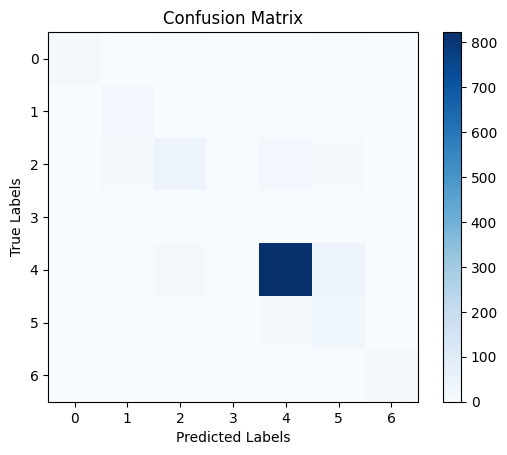

In [37]:
# Plotting the confusion matrix
plt.imshow(confusion_matrix(df_val['cell_type_idx'], predictions), cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar()
plt.show()

In [38]:
confusion_matrix(df_val['cell_type_idx'], predictions)

array([[ 18,   2,   4,   1,   1,   4,   0],
       [  3,  25,   4,   1,   1,   1,   0],
       [  2,   7,  48,   0,  23,   8,   0],
       [  0,   0,   1,   6,   1,   0,   0],
       [  1,   2,  15,   2, 822,  40,   1],
       [  1,   1,   4,   0,   8,  32,   0],
       [  0,   0,   0,   0,   2,   1,  10]])

In [39]:
# value counts for prediction tensor
predictions.unique(return_counts=True)


(tensor([0, 1, 2, 3, 4, 5, 6]), tensor([ 25,  37,  76,  10, 858,  86,  11]))

# Transformer Model Version